In [ ]:
#| default_exp simulation

In primitives
- implement Voronoi cell generator for different cell configuration cases (random, evenly spaced, concave cell, ...)

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import torch, numpy as np

In [ ]:
from vertex_simulation.primitives import *
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'device: {device}\ndtype: {dtype}')

device: cpu
dtype: torch.float32


## Vertex Trajectory Simulations

In [ ]:
#| export
class Simulation(object):
    '''Abstract class for vertex dynamics simulations
    
    Children should implement following methods:
    - `energy(self,...)`: calculates systems energy
    - `force(self,...)` : calculates forces acting on all vertices
    (you can implement either one, or both of the energy and force functions)
    - `sample_trajectory(self,...)`: simulates dynamics and samples vertex trajectories.
    This method should use either force or energy (spatial gradient) to simulate the system dynamics.
    '''
    def __init__(self,m=None):
        '''m: `Monolayer` or `Graph` object (e.g. cells defined as polygons).'''
        pass
    def energy(self):
        '''Computes the total free energy of the system.'''
        pass
    def force(self):
        '''Computes the total force acting on each vertex. Alternatively use F_i = -grad_i(U), where
        grad_i is the spatial gradient with respect to vertex i, and U is the total free energy.
        '''
        pass
    def sample_trajectory(self, T=10000, delta_T=0.001, sample_freq=10):
        '''
        Run simulation for `T` time steps and sample vertex trajectories with frequency `sample_freq`.
        - `T`  : total number of time steps
        - `delta_T`: step size (e.g. for the numerical integration using Euler's method)
        - `sample_freq`: trajectory sampling frequency. Use `assert (T % sample_freq == 0)` in your implementation.
        '''
        pass

In [ ]:
#| export
class Simulation_Honda(Simulation):
    '''Honda et al. definition of Vertex model. This approach defines a phenomenological total free energy 
    (_or_ work function) of the `Monolayer`: `U = Ud + Us + Ua`
    - `Ud` : deformation energy or elastic energy of the cells. For a cell `k`, `Ud[k] = K*(A[k] - A0)^2`
    where `A[k]>=0` is an area of cell `k`, `K>=0` is an elastic constant, and `A0>=0` is a target area.
    - `Us` : membrane surface tension energy. For cell `k`, `Us[k] = Kp*(P[k] - P0)^2`
    where `Kp>=0` is a constant, `P0` is a target perimeter (constant), and `P[k]` is a perimeter of cell `k`.
    - `Ua` : cell-cell adhesion energy, overall energy of adhesion and contractile tensions along 
    cell-cell junctions. `Ua = sum_edges[ Lambda_ij(t)*l_ij ]`, where `Lambda_ij(t)` is a time-dependent value,
    or a constant value, and `l_ij` is edge length between cells `i` and `j`. This (time-dependent) parameter
    can be used to represent active tensions in the simulation.
    
    References:
    - Fletcher A.G., _et al._, _Progress in Biophysics and Molecular Biology_ __113__, 299-326 (2013).
    '''
    def __init__(self, m=None,params={'Ka':1., 'A0':2.3, 'Kp':0.01,'P0':0., 'Lambda_ij':lambda m,t: 1.}):
        '''
        - `m` : `Monolayer` object (`Graph` w/ cells defined as polygons).
        - `params` : simulation parameters for the vertex model. `params` must be a dictionary with following keys,
            * 'Ka' - "elastic" area constant(s),
            * 'A0' - target cell area(s),
            * 'Kp' - "elastic" perimeter constant(s),
            * 'P0' - target cell perimeter(s) {default: 0},
            * 'Lambda_ij' - a function `f(m,t)`, 'Lambda_ij' must accept the cell monolayer (`self.m`) and the simulation time 
            (t=number_of_iters * delta_T) and return a constant (float) or a torch tensor. Size and type of the tensor must be
            the same size and type as the edge lengths tensor computed by the monolayer's `m.length()` method.
        '''
        super().__init__()
        self.m = m # cell monolayer 
        self.params = params # simulation parameters
          
    def energy(self,t):
        '''Computes total free energy U: `U = Ud + Us + Ua`, U is a function of sim-n parameters (`params`), monolayer ('m'),
        and time (used for implementing periodic contractions through `params['Lambda_ij']` function).
        '''
        Ka, A0 = self.params['Ka'], self.params['A0']
        Kp, P0 = self.params['Kp'], self.params['P0']
        Lij = self.params['Lambda_ij'](self.m, t)
        E_tot = torch.sum( Ka*( ( self.m.area() - A0)**2)) + \
        torch.sum( Kp*( ( self.m.perimeter() - P0)**2)) + torch.sum(Lij*self.m.length())
        return E_tot
    
    def sample_trajectory(self, T=1000, delta_T=0.001, sample_freq=10, print_freq=100):
        '''
        Run simulation for `T` time steps and sample vertex trajectories with frequency `sample_freq`.
        - T  : total number of time steps
        - delta_T: step size (e.g. for the numerical integration using Euler's method)
        - sample_freq: trajectory sampling frequency. Use `assert (T % sample_freq == 0)` in your implementation.
        
        Returns:
        t_samples, x_t, Energy_and_maxSpeed:
        - t_samples, x_t : time and vertex positions lists with len(x_t)==len(t_samples).
        - Energy_and_maxSpeed: tuple (t_Energy, Es, maxSpeed), where `Es` and `maxSpeed` are total energies and
        maximum vertex speeds (movements) for each time period in `t_Energy`.
        '''
        assert (T % sample_freq == 0)
        
        t_samples = [] #time for x_t,Es,maxVels
        x_t = [] #positions of vertices
        t_Energy = []
        Es = [] #energies
        maxSpeed = [] #maximum speed for iteration
        
        t_sim = 0 #starting simulation time
        self.m.vertices.requires_grad_(True)
        for k in range(1,T+1):
            self.m.set_zero_grad_() # reset grad accumulator
            
            E_tot = self.energy(t_sim) # total potential energy of the system
            E_tot.backward() # compute gradients w.r.t. vertex positions,dE/dx
            
            dxdt = -self.m.get_vertex_grad() # dx/dt=-dE/dx
            
            with torch.no_grad():
                if (k%sample_freq) == 0:
                    Es.append(E_tot.item()) # record E_tot
                    maxSpeed.append(torch.norm(dxdt,dim=1).max().item())
                    t_Energy.append(t_sim) # time for E_tot, maxSpeed
                    x_t.append(self.m.vertices.x.detach().cpu().clone())
                    t_samples.append(t_sim) # time for x_t
                if (k%print_freq) == 0:
                    print(f'iter:{k}; t={t_sim:2.3f}: E={E_tot.item():5.4g};'+
                          f' max_spd = {torch.norm(dxdt,dim=1).max().item():3.2g}')
                
                self.m.vertices.x += dxdt*delta_T # update vertex positions
            
            t_sim+=delta_T
        
        # record latest vertex positions
        with torch.no_grad():
            x_t.append(self.m.vertices.x.detach().cpu().clone())
            t_samples.append(t_sim)
        return t_samples, x_t, (t_Energy, Es, maxSpeed)

iter:200; t=0.199: E=23.82; max_spd = 1.3
iter:400; t=0.399: E= 13.8; max_spd =   1
iter:600; t=0.599: E=11.61; max_spd = 1.1
iter:800; t=0.799: E=14.19; max_spd = 1.4
iter:1000; t=0.999: E=18.38; max_spd = 0.95


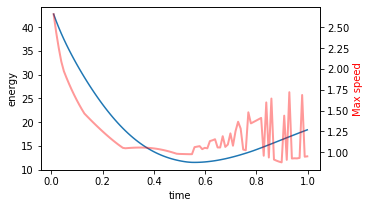

In [ ]:
np.random.seed(42)# np RNG seed
torch.manual_seed(0)# torch RNG seed

v_x,regions =unit_hexagons(4,4) # unit hexagons
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2 #perturb vertices
edge_list,cells = VoronoiRegions2Edges(regions) #convert Voronoi regions to cells & edges
# Define cell monolayer
cell_graph = Monolayer(vertices=Vertex(v_x.copy().tolist(),dtype=dtype), 
                       edges=torch.tensor(edge_list), 
                       cells=cells)
cell_graph.to_(device) # to plot use --> plot_graph_as_quiver(cell_graph)

omega_0 = torch.tensor([np.pi/2],dtype=dtype,device=device)
phase = torch.rand((len(edge_list),1)).type(dtype).to(device)
p_keep = 0.75 # fraction to keep active
e_ij_on = (torch.rand((len(edge_list),1))<p_keep).type(dtype).to(device)
omega = torch.randn_like(e_ij_on) + omega_0

sim = Simulation_Honda(m = cell_graph, params = {'Ka':1., 'A0':2.3,'Kp':0.003,'P0':0.,
                                                 'Lambda_ij': lambda m,t: e_ij_on*torch.cos(omega*t+phase)**2 })
t, verts_t, Energies_maxSpeeds = sim.sample_trajectory(T=1000, delta_T=0.001, sample_freq=10, print_freq=200)

plt.figure(figsize=[5,3])
plt.plot(Energies_maxSpeeds[0],Energies_maxSpeeds[1]);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Max speed',color='red')
ax2.plot(Energies_maxSpeeds[0],Energies_maxSpeeds[2],'r-',alpha=.4,lw=2)
plt.show()

In [ ]:
import networkx as nx
import matplotlib.animation as animation
from IPython.display import HTML
# as a networkx graph
Gnx,pos=graph2networkx_with_pos(cell_graph)
def draw_graph(i):
    if isinstance(verts_t[i],  torch.Tensor):
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    else:
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i]))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Time : {t[i]:2.3f}')
    nx.draw(Gnx,pos,node_size=50,width=4,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')

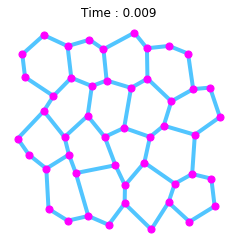

In [ ]:
fig = plt.figure(figsize=[4,4])
fig.clf()
ax = fig.subplots()
ax.axis(False);
draw_graph(0)
plt.show()
plt.close()

anim = animation.FuncAnimation(fig, draw_graph, interval=200, frames = range(0,len(verts_t),4))

In [ ]:
HTML(anim.to_jshtml()) 

In [ ]:
#| export
class Simulation_Honda_t(Simulation_Honda):
    '''Honda et al. definition of Vertex model. Same as the `Simulation_Honda` class, but allows time-dependent 
    `Ka`, `A0`, `Kp`, and `P0` in addition to the time-dependent `Lambda_ij` parameter. For simulation details refer to
    `Simulation_Honda`. Use this class as an example to modify and inherit from `Simulation_Honda` base class.
    
    References:
    - Fletcher A.G., _et al._, _Progress in Biophysics and Molecular Biology_ __113__, 299-326 (2013).
    '''
    def __init__(self, m=None,params={'Ka': lambda m,t: 1., 'A0': lambda m,t: 2.3, 'Kp': lambda m,t: 0.01,
                                      'P0': lambda m,t: 0., 'Lambda_ij':lambda m,t: 1.}):
        super().__init__(m=m,params=params)
          
    def energy(self,t):
        '''Computes total free energy U: `U = Ud + Us + Ua`, U is a function of sim-n parameters (`params`), monolayer ('m'),
        and time (used for implementing periodic contractions through `params['Lambda_ij']` function).
        '''
        Ka, A0 = self.params['Ka'](self.m, t), self.params['A0'](self.m, t)
        Kp, P0 = self.params['Kp'](self.m, t), self.params['P0'](self.m, t)
        Lij = self.params['Lambda_ij'](self.m, t)
        E_tot = torch.sum( Ka*( ( self.m.area() - A0)**2)) + \
        torch.sum( Kp*( ( self.m.perimeter() - P0)**2)) + torch.sum(Lij*self.m.length())
        return E_tot

iter:200; t=0.199: E=74.39; max_spd = 2.6
iter:400; t=0.399: E=50.83; max_spd = 0.77
iter:600; t=0.599: E=60.12; max_spd = 1.6
iter:800; t=0.799: E= 57.9; max_spd = 0.8
iter:1000; t=0.999: E=57.15; max_spd = 0.51


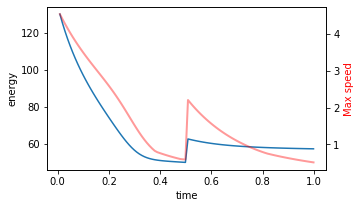

In [ ]:
v_x,regions =unit_hexagons(4,4) # unit hexagons
edge_list,cells = VoronoiRegions2Edges(regions) #convert Voronoi regions to cells & edges
# Define cell monolayer
cell_graph = Monolayer(vertices = Vertex(v_x.copy().tolist(),dtype=dtype), edges = torch.tensor(edge_list),
                       cells = cells)
cell_graph.to_(device) # to plot it use --> plot_graph_as_quiver(cell_graph)

def Ka_t(m,t): return 1.
def A0_t(m,t):
    if t<0.5: C = 1.5
    else: C = 2.3
    return C - 1./ (1 + np.exp(20*(t-0.3)) ) 
def Kp_t(m,t): return 0.003
def P0_t(m,t): return 0.
def Lambda_t(m,t): return 1.

sim_params = {'Ka':Ka_t, 'A0':A0_t, 'Kp':Kp_t, 'P0':P0_t, 'Lambda_ij':Lambda_t}
sim = Simulation_Honda_t(m = cell_graph, params = sim_params)

t, verts_t, Energies_maxSpeeds = sim.sample_trajectory(T=1000, delta_T=0.001, sample_freq=10, print_freq=200)

plt.figure(figsize=[5,3])
plt.plot(Energies_maxSpeeds[0],Energies_maxSpeeds[1]);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Max speed',color='red')
ax2.plot(Energies_maxSpeeds[0],Energies_maxSpeeds[2],'r-',alpha=.4,lw=2)
plt.show()

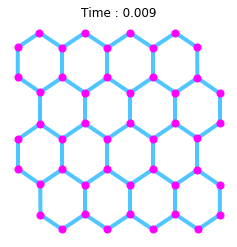

In [ ]:
fig = plt.figure(figsize=[4,4])
fig.clf()
ax = fig.subplots()
ax.axis(False);
draw_graph(0)
plt.show()
plt.close()

anim = animation.FuncAnimation(fig, draw_graph, interval=200, frames = range(0,len(verts_t),4))

In [ ]:
HTML(anim.to_jshtml()) 